In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import fiona
from datetime import datetime, timedelta
from netCDF4 import Dataset, num2date, date2num 
from shapely.geometry import shape, Point

In [2]:
with fiona.open('data/MED_segments.gpkg', 'r') as source:
    #print source.bounds
    for f in source[:100]:
        geom = shape(f['geometry'])
        _centroid = geom.centroid
        lat = f['properties'].get('Lati')
        lon = f['properties'].get('Longi')
        slope = f['properties'].get('MCD_segment_level_2_cst')
        
        centroid = Point(lon, lat)
        
        mylon = _centroid.x
        mylat = _centroid.y
        print "lat e lon to query: " + str(mylat) + ',' + str(mylon)

lat e lon to query: 42.9197296309,17.5903302855
lat e lon to query: 42.180191538,18.9678505649
lat e lon to query: 42.1644850213,18.9835156924
lat e lon to query: 42.1596142042,18.9996989668
lat e lon to query: 42.1404232293,19.015894162
lat e lon to query: 42.0345349918,19.1416700384
lat e lon to query: 42.1191926907,19.0700434225
lat e lon to query: 42.0733357298,19.095130574
lat e lon to query: 42.0402614488,19.1415749931
lat e lon to query: 42.0997639206,19.0868327987
lat e lon to query: 42.0291592176,19.143091105
lat e lon to query: 42.1360294596,19.0421871197
lat e lon to query: 42.2203666088,18.9104604665
lat e lon to query: 42.2840867941,18.8465331635
lat e lon to query: 42.2809375222,18.8572480774
lat e lon to query: 42.2771704205,18.8605410025
lat e lon to query: 42.265431244,18.8522714477
lat e lon to query: 42.2768060996,18.7973612486
lat e lon to query: 42.2414802049,18.8979436132
lat e lon to query: 42.1975165781,18.9506118976
lat e lon to query: 42.2772048021,18.88102468

/opt/VirtEnv/iws/local/lib/python2.7/site-packages/fiona/collection.py:336: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


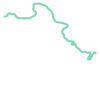

In [3]:
geom

In [4]:
sealevel = Dataset("data/TMES_sea_level_20181029.nc", "r", format="NETCDF4")
print sealevel.variables
lat = sealevel.variables["lat"]
lon = sealevel.variables["lon"]
times = sealevel.variables["time"]
dates = num2date(times[:],units=times.units,calendar=times.calendar)
for date in dates:
    print date.isoformat(' ')
         


OrderedDict([(u'time', <type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: seconds since 2018-01-01 00:00:00 UTC
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (24,)
filling off
), (u'lon', <type 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (509,)
filling off
), (u'lat', <type 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (460,)
filling off
), (u'sea_level-mean', <type 'netCDF4._netCDF4.Variable'>
float32 sea_level-mean(time, lat, lon)
    units: m
    _FillValue: -999.0
    missing_value: -999.0
unlimited dimensions: time
current shape = (24, 460, 509)
filling off
), (u'sea_level-std', <type 'netCDF4._netCDF4.Variable'>
float32 sea_level-std(time, lat, lon)
    uni

In [18]:
sealevel['sea_level-mean'][0]

masked_array(data = [ 36.66999817  36.68999863  36.70999908  36.72999954  36.75        36.76999664
  36.7899971   36.80999756  36.82999802  36.84999847  36.86999893
  36.88999939  36.90999985  36.92999649  36.94999695  36.96999741
  36.98999786  37.00999832  37.02999878  37.04999924  37.06999969
  37.08999634  37.1099968   37.12999725  37.14999771  37.16999817
  37.18999863  37.20999908  37.22999954  37.25        37.26999664
  37.2899971   37.30999756  37.32999802  37.34999847  37.36999893
  37.38999939  37.40999985  37.42999649  37.44999695  37.46999741
  37.48999786  37.50999832  37.52999878  37.54999924  37.56999969
  37.58999634  37.6099968   37.62999725  37.64999771  37.66999817
  37.68999863  37.70999908  37.72999954  37.75        37.76999664
  37.7899971   37.80999756  37.82999802  37.84999847  37.86999893
  37.88999939  37.90999985  37.92999649  37.94999695  37.96999741
  37.98999786  38.00999832  38.02999878  38.04999924  38.06999969
  38.08999634  38.1099968   38.12999725  38

In [118]:
#code from 
#https://www.unidata.ucar.edu/blogs/developer/entry/accessing_netcdf_data_by_coordinates
#https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb


def naive_slow(latvar,lonvar,lat0,lon0):
    '''
    Find "closest" point in a set of (lat,lon) points to specified point
    latvar - 2D latitude variable from an open netCDF dataset
    lonvar - 2D longitude variable from an open netCDF dataset
    lat0,lon0 - query point
    Returns iy,ix such that 
     (lonval[iy,ix] - lon0)**2 + (latval[iy,ix] - lat0)**2
    is minimum.  This "closeness" measure works badly near poles and
    longitude boundaries.
    '''
    # Read from file into numpy arrays
    latvals = latvar[:]
    lonvals = lonvar[:]
    ny = len(latvals)
    nx = len(lonvals)
    dist_sq_min = 1.0e30
    for iy in range(ny):
        for ix in range(nx):
            latval = latvals[iy]
            lonval = lonvals[ix]
            dist_sq = (latval - lat0)**2 + (lonval - lon0)**2
            if dist_sq < dist_sq_min:
                iy_min, ix_min, dist_sq_min = iy, ix, dist_sq
    return iy_min,ix_min


mysealevel = sealevel.variables["sea_level-mean"]
print mysealevel[:]
#
with fiona.open('data/MED_segments.gpkg', 'r') as source:
    latvar = sealevel.variables["lat"]
    lonvar = sealevel.variables["lon"]
    for f in source[100:110]:
        geom = shape(f['geometry'])
        _centroid = geom.centroid
        mylon = _centroid.x
        mylat = _centroid.y
        iy,ix = naive_slow(latvar, lonvar, lat, lon)
        print 'Point: ' + str(mylat) +',' + str(mylon)
        print 'Closest point: ' + str(lat[iy]), str(lon[ix])
        print mysealevel[0, iy, ix]



[[[-- -- -- ..., -0.44731613993644714 -0.4477744400501251 --]
  [-- -- -- ..., -0.44778189063072205 -- --]
  [-- -- -- ..., -0.44763851165771484 -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -0.43053919076919556 -0.43117064237594604 --]
  [-- -- -- ..., -0.4310973882675171 -- --]
  [-- -- -- ..., -0.43103286623954773 -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -0.4126896262168884 -0.41343069076538086 --]
  [-- -- -- ..., -0.41326406598091125 -- --]
  [-- -- -- ..., -0.4132128059864044 -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 ..., 
 [[-- -- -- ..., -0.4452746510505676 -0.4458840489387512 --]
  [-- -- -- ..., -0.4455030560493469 -- --]
  [-- -- -- ..., -0.44528359174728394 -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -0.4385

In [33]:
sealevel['sea_level-mean'][0].mask[230,300]

False

In [38]:
sealevel['lat'][:].shape

(460,)

In [26]:
lats = np.array([45, 46, 47])
lons = np.array([12, 13, 14, 15])


print(np.repeat([lons], lats.shape[0], axis=0))

np.repeat(np.reshape(lats, [lons.shape[0],1]), , axis=1)

[[12 13 14 15]
 [12 13 14 15]
 [12 13 14 15]]


array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])